# Twitter Sentiment Analysis (Spanish)
In this notebook you will see an example of the processes necessary to perform an analysis of feelings about Tweets in spanish. For this we will have to follow the following steps:
1. Getting a Corpus: it's nothing more than a database of tagged text
2. Clean up the data
3. Processing the text
4. Modeling
5. 
6. 

**These programs are very useful in marketing campaigns, to monitor the launch of a new product, track events on Twitter, or simply have certain accounts or hashtags monitored to have a real time analysis program.**

## 1. Corpus in spanish
To get the corpus in Spanish we will have to register on the [TASS page](http://tass.sepln.org/tass_data/download.php ), which is a semantic analysis association that is responsible for collecting text and keeping it labeled.

- Imports

In [37]:
import pandas as pd
import numpy as np
import re

import xml.etree.ElementTree as ET
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

 - Reading the dataset

In [38]:
tree = ET.parse('../data/general-train-tagged.xml')
root = tree.getroot()

In [ ]:
# parse and label the data

In [39]:
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)


(7219, 6)


In [40]:

pd.set_option('max_colwidth', None)
df.head()

,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/nos. Besos y gracias,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!,2011-12-02T02:59:03,es,P+,AGREEMENT


 - Polarity column

In [41]:
# unique values
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

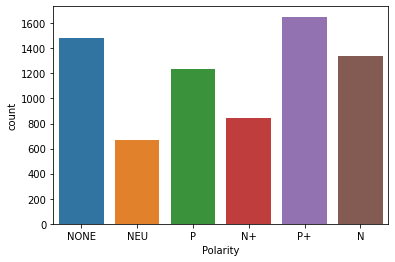

In [42]:
sns.countplot(x = 'Polarity', data=df);

 - Type column

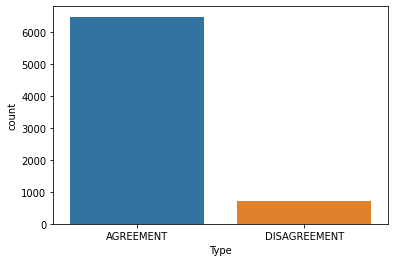

In [43]:
sns.countplot(x = 'Type', data=df);

## 2. Data cleaning

#### Polarity
We are going to classify the Tweets as positive or negative, so we will do the following grouping of the polarity

In [44]:
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 0
    elif x in ('N', 'N+'):
        return 1

In [45]:
# we eliminate the neutrals
df = df[~df['Polarity'].isin(['NONE', 'NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [46]:
# positive is 1 and negative 0
df['Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

array([0, 1], dtype=int64)

#### Language
We keep the tweets in spanish.

In [47]:
df = df[df['Lang'] == 'es']

#### Duplicates

In [48]:
df.drop_duplicates(subset = 'Content', inplace=True)
df.shape

(5052, 6)

In [49]:
df.reset_index(inplace=True)
df.shape

(5052, 7)

## 3. Text processing

 - Removing links

In [50]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content'] = df['Content'].apply(remove_links)

In [51]:
df['Content'].head()

0                                                                                                                    @marodriguezb Gracias MAR
1           Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)
2                                                                            Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!
3                                                                        Toca @crackoviadeTV3 . Grabación dl especial Navideño...Mari crismas!
4    Buen día todos! Lo primero mandar un abrazo grande a Miguel y a su familia @libertadmontes Hoy podría ser un día para la grandeza humana.
Name: Content, dtype: object

 - Removing '@users'

In [52]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

df['Content'] = np.vectorize(remove_pattern)(df['Content'], "@[\w]*")
df['Content'].head()

0                                                                                                                           Gracias MAR
1    Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)
2                                                                     Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!
3                                                                                Toca  . Grabación dl especial Navideño...Mari crismas!
4            Buen día todos! Lo primero mandar un abrazo grande a Miguel y a su familia  Hoy podría ser un día para la grandeza humana.
Name: Content, dtype: object

 - Removing Punctuations, Numbers and Special characters

In [53]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\¡)|(\?)|(\¿)|(\@)|(\#)|(\%)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)|(\⃣)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content'] = df['Content'].apply(signs_tweets)
df['Content'].head()

0                                                                                                                       gracias mar
1    off pensando en el regalito sinde la que se va de la sgae cuando se van sus corruptos intento no sacar conclusiones lo intento
2                                                                   conozco a alguien q es adicto al drama ja ja ja te suena d algo
3                                                                                 toca   grabación dl especial navideñomari crismas
4          buen día todos lo primero mandar un abrazo grande a miguel y a su familia  hoy podría ser un día para la grandeza humana
Name: Content, dtype: object

## 4. Model
To assemble the model we will have to follow the following steps
1. We eliminate stopwords
2. We apply a stemmer, SnowBall for example

#### Stopwords

In [54]:
from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

In [55]:
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [56]:
df['Content'] = df['Content'].apply(remove_stopwords)
df.head()

,index,User,Content,Date,Lang,Polarity,Type
0,2,CarmendelRiego,gracias mar,2011-12-02T00:57:40,es,0,AGREEMENT
1,3,mgilguerrero,off pensando regalito sinde va sgae van corruptos intento sacar conclusiones intento,2011-12-02T02:33:37,es,1,AGREEMENT
2,4,paurubio,conozco alguien q adicto drama ja ja ja suena d,2011-12-02T02:59:03,es,0,AGREEMENT
3,6,Carlos_Latre,toca grabación dl especial navideñomari crismas,2011-12-02T07:00:50,es,0,AGREEMENT
4,8,nacho_uriarte,buen día primero mandar abrazo grande miguel familia hoy podría ser día grandeza humana,2011-12-02T07:45:05,es,0,AGREEMENT


#### Stemmer

In [57]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content'] = df['Content'].apply(spanish_stemmer)
df['Content'].head()

0                                                                        graci mar
1            off pens regalit sind va sga van corrupt intent sac conclusion intent
2                                        conozc algui q adict dram ja ja ja suen d
3                                     toc grabacion dl especial navideñomari crism
4    buen dia primer mand abraz grand miguel famili hoy podr ser dia grandez human
Name: Content, dtype: object

 -  Feature selection
We keep the columns that interest us for the model

In [58]:
df = df[['Content', 'Polarity']]

In [59]:
df.to_csv('../data/data_processed_for_model.csv')

 - Vectorizer

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))

Pipeline for Logistic Regression, as usually works well with few observations and many features:

In [61]:
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [63]:

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LogisticRegression())
])

parameters = {
    'vect__max_df': (0.1, 0.5, 1 , 1.9),
    'vect__min_df': (1, 5, 10, 20,50),
    'vect__max_features': (500, 1000, 1500),
    "cls__penalty": ["l1","l2"], 
    "cls__C": [0.1, 0.5, 1.0, 5.0] 

}

grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

Fitting:

In [64]:
grid_search.fit(df['Content'], df['Polarity'])

c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.72822928 0.72763542 0.72842769 0.71951798 0.67973049 0.74149073
 0.74168777 0.73416694 0.71951798 0.67973049 0.74604303 0.74703313
 0.73416694 0.71951798 0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cls__C': [0.1, 0.5, 1.0, 5.0],
                         'cls__penalty': ['l1', 'l2'],
                         'vect__max_df': (0.1, 0.5, 1, 1.9),
                         'vect__max_features': (500, 1000, 1500),
                         'vect__min_df': (1, 5, 10, 20, 50)},
             scoring='accuracy')

In [65]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

Best params: {'cls__C': 0.5, 'cls__penalty': 'l2', 'vect__max_df': 0.5, 'vect__max_features': 1500, 'vect__min_df': 5}
Best acc: 0.7589098138300476
Best model: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1500, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])


In [66]:
grid_search.best_estimator_['cls']

LogisticRegression(C=0.5)

Saving the model:

In [67]:
import pickle

with open('../model/finished_model_LR.model', "wb") as archivo_salida:
    pickle.dump(grid_search.best_estimator_, archivo_salida)

## 4. Predictions

In [68]:
with open('data/output/finished_model.model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)

#### Leemos el pipeline con el modelo

In [73]:
text = pd.Series('El bombardeo de #Gernika por parte de la aviación nazi y fascista fue uno de los episodios más cruentos de la Guerra Civil. 85 años después, recordamos este día y a todas sus víctimas. Porque la memoria es imprescindible para seguir construyendo una sociedad democrática y en paz.')
test_clean = pd.DataFrame(text, columns=['content'])

In [74]:
test_clean

,content
0,"El bombardeo de #Gernika por parte de la aviación nazi y fascista fue uno de los episodios más cruentos de la Guerra Civil. 85 años después, recordamos este día y a todas sus víctimas. Porque la memoria es imprescindible para seguir construyendo una sociedad democrática y en paz."


In [77]:


# mismas trans q en train

# links
test_clean['content_clean'] = test_clean['content'].apply(remove_links)

# mentions
#test_clean['content_clean'] = np.vectorize(remove_pattern)(df['content_clean'], "@[\w]*")

# punstuation and signs
test_clean['content_clean'] = test_clean['content_clean'].apply(signs_tweets)

# stopwords
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_stopwords)

# Stemmer
test_clean['content_clean'] = test_clean['content_clean'].apply(spanish_stemmer)

In [79]:
pd.set_option('display.max_colwidth', None)
test_clean

,content,content_clean
0,"El bombardeo de #Gernika por parte de la aviación nazi y fascista fue uno de los episodios más cruentos de la Guerra Civil. 85 años después, recordamos este día y a todas sus víctimas. Porque la memoria es imprescindible para seguir construyendo una sociedad democrática y en paz.",bombarde gernik part aviacion nazi fascist episodi cruent guerr civil años despues record dia tod victim memori imprescind segu constru socied democrat paz


#### Predicciones de test

In [80]:
predictions = pipeline_importada.predict(test_clean['content_clean'])
test_clean['Polarity'] = pd.Series(predictions)
test_clean

,content,content_clean,Polarity
0,"El bombardeo de #Gernika por parte de la aviación nazi y fascista fue uno de los episodios más cruentos de la Guerra Civil. 85 años después, recordamos este día y a todas sus víctimas. Porque la memoria es imprescindible para seguir construyendo una sociedad democrática y en paz.",bombarde gernik part aviacion nazi fascist episodi cruent guerr civil años despues record dia tod victim memori imprescind segu constru socied democrat paz,1


In [ ]:
# negativo

In [ ]:
# probabilidades de pertenencia a cada clase:

In [81]:
predictions = pipeline_importada.predict_proba(test_clean['content_clean'])
test_clean['Polarity_Pos'] = pd.Series(predictions[0][0])
test_clean['Polarity_Neg'] = pd.Series(predictions[0][1])
test_clean

,content,content_clean,Polarity,Polarity_Pos,Polarity_Neg
0,"El bombardeo de #Gernika por parte de la aviación nazi y fascista fue uno de los episodios más cruentos de la Guerra Civil. 85 años después, recordamos este día y a todas sus víctimas. Porque la memoria es imprescindible para seguir construyendo una sociedad democrática y en paz.",bombarde gernik part aviacion nazi fascist episodi cruent guerr civil años despues record dia tod victim memori imprescind segu constru socied democrat paz,1,0.444031,0.555969
